# Description

In this code, we perform Gaussian Naive Bayes with forward selection. Like the logistic regression, we formerly used SMOTE.

# Load the data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
df = pd.read_csv('./preprocessed_TJI_deaths.csv')

# Split into races

In [ ]:
print('Before dropping race OTHER: ', df.shape[0])
df = df[df['race']!='OTHER']
print('After dropping race OTHER: ', df.shape[0])
df_white = df[df['race']=='WHITE']
df_black = df[df['race']=='BLACK']
df_hispanic = df[df['race']=='HISPANIC']

Before dropping race OTHER:  10713
After dropping race OTHER:  10620


In [ ]:
print('White prisoners: ', df_white.shape)
print('Black prisoners: ', df_black.shape)
print('Hispanic prisoners: ', df_hispanic.shape)

White prisoners:  (4609, 10)
Black prisoners:  (3120, 10)
Hispanic prisoners:  (2888, 10)


# White Naive Bayes (w/ forward selection)

With SMOTE, this takes around 20 minutes to run. Without SMOTE, this takes around 11 minutes.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
df_white = df[df['race']=='WHITE']

df_white_Y = df_white['Natural']
df_white_X = df_white.drop(['Natural', 'manner_of_death', 'race'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_white_X, df_white_Y, test_size=0.2)

In [ ]:
numerical_columns = ['age_at_time_of_death', 'days_from_custody_to_death']
binary_columns = ['sex', 'Medical']
categorical_columns = [col for col in X_train.columns if col not in numerical_columns + binary_columns]

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('binary', OrdinalEncoder(), binary_columns)
])

model_white = GaussianNB()

sfs_white = SFS(
    estimator = model_white,
    k_features = 'best',
    forward = True,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = -1
)

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
#    ('smote', SMOTE(sampling_strategy='auto')),
    ('forward_selection', sfs_white),
    ('model', model_white)
])


cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__var_smoothing': np.logspace(0, -10, num=20)}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model_white = gridsearch.best_estimator_

CV-results:
 [0.88346883 0.88888889 0.91327913 0.90243902 0.88075881 0.91056911
 0.90243902 0.92119565 0.91304348 0.9048913 ] 
-------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best hyperparameters: {'model__var_smoothing': 0.08858667904100828} 
-------------------------------


In [ ]:

y_pred = best_model_white.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)


Test accuracy:  0.89587852494577


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[719  39]
 [ 57 107]]
              precision    recall  f1-score   support

     Natural       0.93      0.95      0.94       758
   Unnatural       0.73      0.65      0.69       164

    accuracy                           0.90       922
   macro avg       0.83      0.80      0.81       922
weighted avg       0.89      0.90      0.89       922



In [ ]:
preprocess_pipeline = best_model_white.named_steps['preprocess']
one_hot = preprocess_pipeline.transformers_[1][1]

#Check the categories of the one-hot encoding:
categories_OH = one_hot.categories_
categories_OH = [category for feature in categories_OH for category in feature]
print(categories_OH)

#Check the ordinal encoding:
ordinal = preprocess_pipeline.transformers_[2][1]
categories_bin = ordinal.categories_
categories_bin = [category for feature in categories_bin for category in feature]

print(categories_bin)

#Check the label encoding:
model = best_model_white.named_steps['model']
print('Labels: ', model.classes_, "\n-------------------------------")

['JAIL - COUNTY', 'JAIL - MUNICIPAL', 'PRISON', 'PRIVATE FACILITY', 'Non-violent', 'Sexual', 'Violent', 'afternoon', 'morning', 'night']
['FEMALE', 'MALE', False, True]
Labels:  ['Natural' 'Unnatural'] 
-------------------------------


In [ ]:
thetas_white = best_model_white.named_steps['model'].theta_

numerical_col = ['Age', 'Days']
categorical_col = categories_OH
binary_col = ['Male', 'Pre-existing conditions']

all_features = numerical_col + list(categorical_col) + list(binary_col)
#print(all_features)

sfs_white_steps = best_model_white.named_steps['forward_selection']
selected_features_white = [all_features[i] for i in sfs_white_steps.k_feature_idx_]

print(selected_features_white)

col_names = selected_features_white

thetas_df_white = pd.DataFrame(thetas_white, columns = col_names, index = ['Natural causes', 'Unnatural causes'])
thetas_df_white = thetas_df_white.reset_index().rename(columns={'index': 'Cause'})

difference_white_values = thetas_df_white.iloc[1, 1:].values - thetas_df_white.iloc[0, 1:].values
difference_white_values = difference_white_values.reshape(1, -1)
difference_df_white = pd.DataFrame(difference_white_values, columns = col_names, index = ['Unnatural - Natural'])
difference_df_white = difference_df_white.reset_index().rename(columns={'index': 'Cause'})

print(difference_df_white)

['Age', 'PRISON', 'Violent', 'night', 'Pre-existing conditions']
                 Cause      Age    PRISON   Violent     night  \
0  Unnatural - Natural -1.38783 -0.381798  0.091964 -0.103487   

  Pre-existing conditions  
0               -0.493486  


# Black Naive Bayes (w/ forward selection)

In [ ]:
df_black_Y = df_black['Natural']
df_black_X = df_black.drop(['Natural', 'manner_of_death', 'race'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_black_X, df_black_Y, test_size=0.2)

In [ ]:
numerical_columns = ['age_at_time_of_death', 'days_from_custody_to_death']
binary_columns = ['sex', 'Medical']
categorical_columns = [col for col in X_train.columns if col not in numerical_columns + binary_columns]

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('binary', OrdinalEncoder(), binary_columns)
])

model_black = GaussianNB()

sfs_black = SFS(
    estimator = model_black,
    k_features = 'best',
    forward = True,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = -1
)

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
#    ('smote', SMOTE(sampling_strategy='auto')),
    ('forward_selection', sfs_black),
    ('model', model_black)
])


cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__var_smoothing': np.logspace(0, -10, num=20)}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model_black = gridsearch.best_estimator_

CV-results:
 [0.904      0.888      0.904      0.884      0.88       0.9
 0.87550201 0.87951807 0.91164659 0.89959839] 
-------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best hyperparameters: {'model__var_smoothing': 0.08858667904100828} 
-------------------------------


In [ ]:
y_pred = best_model_black.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

Test accuracy:  0.8910256410256411


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[502  25]
 [ 43  54]]
              precision    recall  f1-score   support

     Natural       0.92      0.95      0.94       527
   Unnatural       0.68      0.56      0.61        97

    accuracy                           0.89       624
   macro avg       0.80      0.75      0.78       624
weighted avg       0.88      0.89      0.89       624



In [ ]:
thetas_black = best_model_black.named_steps['model'].theta_

numerical_col = ['Age', 'Days']
categorical_col = categories_OH
binary_col = ['Male', 'Pre-existing conditions']

all_features = numerical_col + list(categorical_col) + list(binary_col)

sfs_black_steps = best_model_black.named_steps['forward_selection']
selected_features_black = [all_features[i] for i in sfs_black_steps.k_feature_idx_]

print(selected_features_black)


col_names = selected_features_black

thetas_df_black = pd.DataFrame(thetas_black, columns = col_names, index = ['Natural causes', 'Unnatural causes'])
thetas_df_black = thetas_df_black.reset_index().rename(columns={'index': 'Cause'})

difference_black_values = thetas_df_black.iloc[1, 1:].values - thetas_df_black.iloc[0, 1:].values
difference_black_values = difference_black_values.reshape(1, -1)
difference_df_black = pd.DataFrame(difference_black_values, columns = col_names, index = ['Unnatural - Natural'])
difference_df_black = difference_df_black.reset_index().rename(columns={'index': 'Cause'})

print(difference_df_black)

['Age', 'Days', 'JAIL - MUNICIPAL', 'Sexual', 'morning', 'Pre-existing conditions']
                 Cause       Age      Days JAIL - MUNICIPAL    Sexual  \
0  Unnatural - Natural -1.198857 -0.359801         0.037411 -0.107073   

    morning Pre-existing conditions  
0  0.014779               -0.459647  


# Hispanic Naive Bayes (w/ forward selection)

In [ ]:
df_hispanic_Y = df_hispanic['Natural']
df_hispanic_X = df_hispanic.drop(['Natural', 'manner_of_death', 'race'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_hispanic_X, df_hispanic_Y, test_size=0.2)

In [ ]:
numerical_columns = ['age_at_time_of_death', 'days_from_custody_to_death']
binary_columns = ['sex', 'Medical']
categorical_columns = [col for col in X_train.columns if col not in numerical_columns + binary_columns]

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('binary', OrdinalEncoder(), binary_columns)
])

model_hispanic = GaussianNB()

sfs_hispanic = SFS(
    estimator = model_hispanic,
    k_features = 'best',
    forward = True,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = -1
)

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
#    ('smote', SMOTE(sampling_strategy='auto')),
    ('forward_selection', sfs_hispanic),
    ('model', model_hispanic)
])


cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__var_smoothing': np.logspace(0, -10, num=20)}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model_hispanic = gridsearch.best_estimator_

CV-results:
 [0.90909091 0.9047619  0.84848485 0.85714286 0.9047619  0.8961039
 0.89177489 0.85714286 0.9004329  0.85714286] 
-------------------------------
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best hyperparameters: {'model__var_smoothing': 0.026366508987303583} 
-------------------------------


In [ ]:
y_pred = best_model_hispanic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

Test accuracy:  0.8979238754325259


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[437  30]
 [ 29  82]]
              precision    recall  f1-score   support

     Natural       0.94      0.94      0.94       467
   Unnatural       0.73      0.74      0.74       111

    accuracy                           0.90       578
   macro avg       0.83      0.84      0.84       578
weighted avg       0.90      0.90      0.90       578



In [ ]:
thetas_hispanic = best_model_hispanic.named_steps['model'].theta_

numerical_col = ['Age', 'Days']
categorical_col = categories_OH
binary_col = ['Male', 'Pre-existing conditions']

all_features = numerical_col + list(categorical_col) + list(binary_col)
#print(all_features)

sfs_hispanic_steps = best_model_hispanic.named_steps['forward_selection']
selected_features_hispanic = [all_features[i] for i in sfs_hispanic_steps.k_feature_idx_]

print(selected_features_hispanic)


col_names = selected_features_hispanic

thetas_df_hispanic = pd.DataFrame(thetas_hispanic, columns = col_names, index = ['Natural causes', 'Unnatural causes'])
thetas_df_hispanic = thetas_df_hispanic.reset_index().rename(columns={'index': 'Cause'})

difference_hispanic_values = thetas_df_hispanic.iloc[1, 1:].values - thetas_df_hispanic.iloc[0, 1:].values
difference_hispanic_values = difference_hispanic_values.reshape(1, -1)
difference_df_hispanic = pd.DataFrame(difference_hispanic_values, columns = col_names, index = ['Unnatural - Natural'])
difference_df_hispanic = difference_df_hispanic.reset_index().rename(columns={'index': 'Cause'})

print(difference_df_hispanic)

['Age', 'JAIL - COUNTY', 'PRISON', 'PRIVATE FACILITY', 'Non-violent', 'Sexual', 'Violent', 'afternoon', 'morning', 'night', 'Pre-existing conditions']
                 Cause       Age JAIL - COUNTY    PRISON PRIVATE FACILITY  \
0  Unnatural - Natural -1.315926      0.207105 -0.311088         0.020502   

  Non-violent    Sexual   Violent afternoon   morning     night  \
0    0.039251 -0.170802  0.131551  0.100562  0.042895 -0.143457   

  Pre-existing conditions  
0               -0.504618  


#Visualize centers

In [ ]:
def visualize_centers(df_white, df_black, df_hisp):

  #Melt each dataframe into a long format
  df_white_melt = df_white.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Center')
  df_black_melt = df_black.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Center')
  df_hisp_melt = df_hisp.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Center')

  #Add race to long dfs
  df_white_melt['race'] = 'White'
  df_black_melt['race'] = 'Black'
  df_hisp_melt['race'] = 'Hispanic'

  #Combine the long dfs
  df_vis = pd.concat([df_white_melt, df_black_melt, df_hisp_melt])

  causes = df_vis['Cause'].unique()

  for cause in causes:

    cause_df = df_vis[df_vis['Cause']==cause]

    sns.barplot(x='Feature', y='∆Center (Unnatural - Natural)', hue='race',
              data=cause_df, ci=None, palette='muted')

    plt.title(f'Death by {cause}')

    plt.axhline(y=0)

    plt.xticks(rotation=90)

    plt.show()

<ipython-input-26-2811ca10959a>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Feature', y='Center', hue='race',


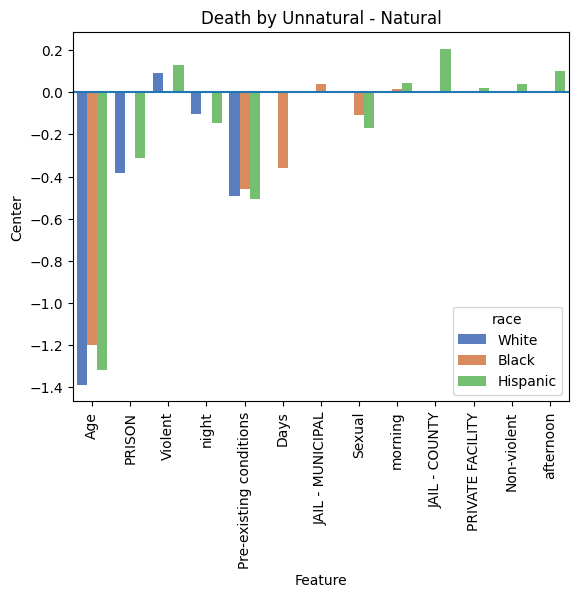

In [ ]:
visualize_centers(difference_df_white, difference_df_black, difference_df_hispanic)

# General Remarks

In our presentation, we discussed how logistic regression surprisingly outperformed Gaussian NB. However, after removing SMOTE (as well as using ordinal encoding instead of one-hot encoding for binary variables), we obtain a good overall performance across all races. Ordinal encoding was likely a great driving factor in this, as using one-hot encoding for binary variables introduced features that were collinear. This is detrimental to Naive Bayes, which assumes feature independence.